In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('gdrive/My Drive/BraTS20')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from sklearn.metrics import confusion_matrix
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Brown => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [3]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 24
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'AttUnet_01' #save version 
dropout=0.3 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = 'gdrive/My Drive/BraTS20/BraTS20_tfrecords03/HGG/'
# Open a file
path = 'gdrive/My Drive/BraTS20/Training_pre'

---

# Helper Functions

In [4]:
def dice_coef_bool(y_true, y_pred):
    '''
    Dice coefficient for tensorflow (boolean version)
    * None differiantiable!
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: dice coefficient
    '''
    if (tf.rank(y_true) != 1 and tf.rank(y_pred) != 1):
        y_true = tf.reshape(y_true, [-1])  # flatten
        y_pred = tf.reshape(y_pred, [-1])  # flatten

    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    intersection = tf.math.count_nonzero(y_true & y_pred)

    size_i1 = tf.math.count_nonzero(y_true)
    size_i2 = tf.math.count_nonzero(y_pred)
    summation = size_i1 + size_i2

    if summation != 0:
        dc = (2.0 * tf.cast(intersection, tf.float32) / tf.cast(summation, tf.float32)).numpy()
    else:
        dc = 1.0

    return dc


def ss_metric(y_true, y_pred, label_type='binary', mode='global', smooth=1e-5):
    '''
    Compute sensitivity and specificity for groundtruth and prediction
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :label_type: 'binary': input labels is binarized
                 'multi': mutli class labels
    :mode: 'local' compute the sensitivity label wise
           'global' compute the sensitivity overall
    :return: sensitivity & specificity
    '''
    # if input is not flatten
    if (tf.rank(y_true) != 1 and tf.rank(y_pred) != 1):
        y_true = tf.reshape(y_true, [-1])  # flatten
        y_pred = tf.reshape(y_pred, [-1])  # flatten
    # label types
    if label_type == 'binary':
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        sensitivity = (tp + smooth) / (tp + fn + smooth)
        specificity = (tn + smooth) / (tn + fp + smooth)
    if label_type == 'multi':
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
        # true positive rate
        if mode == 'global':
            tp = np.trace(cm)
            tp_fn = np.sum(cm)
        else:  # local
            tp = np.diag(cm)
            tp_fn = np.sum(cm, 1)
        sensitivity = (tp + smooth) / (tp_fn + smooth)
        # true negative rate
        diag = np.diag(cm)
        tn = []
        for i in range(len(cm)):
            negs = np.sum([neg for neg in diag if neg != diag[i]])
            tn.append(negs)
        cm_copy = cm
        # make diagonal 0
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i == j:
                    cm_copy[i, j] = 0
        if mode == 'global':
            tn = np.sum(tn)
            fp = np.sum(cm_copy)
        else:  # local
            tn = np.array(tn)
            fp = np.sum(cm_copy, 0)
        specificity = (tn + smooth) / (tn + fp + smooth)
    return sensitivity, specificity


def compute_metric(y_true, y_pred, label_type='binary'):
    '''
    This function compute the metrics specify by BraTS competition
    which is dice coefficient, sensitivity, specificity
    :param y_true: Ground truth image
    :param y_pred: Prediction image from the model
    :label_type: 'binary': input labels is binarized
             'multi': mutli class labels
    :return: dice coefficient, sensitivity & specificity list
            with order ['core', 'enhancing', 'complete']
    '''
    y_list = [y_true, y_pred]
    tumours = ['core', 'enhancing', 'complete']
    dc_output = []
    sens_output = []
    spec_output = []
    # compute dice coefficient for each tumour type
    for tumour_type in tumours:
        if label_type == 'multi':
            # label 1, 3(4)
            if tumour_type == 'core':
                y_true, y_pred = [np.where(((lbl == 1) | (lbl == 3)), lbl, 0) for lbl in y_list]
            # label 3(4)
            if tumour_type == 'enhancing':
                y_true, y_pred = [np.where(lbl == 3, lbl, 0) for lbl in y_list]
            # label 1,2,3,
            if tumour_type == 'complete':
                y_true, y_pred = [np.where(lbl > 0, lbl, 0) for lbl in y_list]
        if label_type == 'binary':
            # label 1, 3(4) =>1
            if tumour_type == 'core':
                y_true, y_pred = [np.where(((lbl == 1) | (lbl == 3)), 1, 0) for lbl in y_list]
            # label 3(4) =>1
            if tumour_type == 'enhancing':
                y_true, y_pred = [np.where(lbl == 3, 1, 0) for lbl in y_list]
            # label 1,2,3 =>1
            if tumour_type == 'complete':
                y_true, y_pred = [np.where(lbl > 0, 1, 0) for lbl in y_list]
        dc_list = []
        sens_list = []
        spec_list = []
        # only single images [240, 240]
        if y_true.ndim == 2:
            dc = dice_coef_bool(y_true, y_pred)
            sensitivity, specificity = ss_metric(y_true, y_pred)
            # append for each tumour type
            dc_output.append(dc)
            sens_output.append(sensitivity)
            spec_output.append(specificity)
            # batched images [?,240,240]
        else:
            for idx in range(len(y_true)):
                y_true_f = tf.reshape(y_true[idx], [-1])  # flatten
                y_pred_f = tf.reshape(y_pred[idx], [-1])  # flatten

                dc = dice_coef_bool(y_true_f, y_pred_f)
                sensitivity, specificity = ss_metric(y_true_f, y_pred_f)
                # store values
                dc_list.append(dc)
                sens_list.append(sensitivity)
                spec_list.append(specificity)
            # output [BATCH_SIZE, tumours_type]
            # taking the mean along the batch axis
            mean_ = lambda x: np.mean(x)
            dc_batch_mean = mean_(dc_list)
            sens_batch_mean = mean_(sens_list)
            spec_batch_mean = mean_(spec_list)
            # append for each tumour type
            dc_output.append(dc_batch_mean)
            sens_output.append(sens_batch_mean)
            spec_output.append(spec_batch_mean)
    # for each list the order is as following=> 'core','enhancing','complete'
    return dc_output, sens_output, spec_output


xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

def data_aug(imgs, seed=8888):
    x = tf.image.random_flip_up_down(imgs,seed)
    x = tf.image.random_flip_left_right(x,seed)
    return x

----

# Model

In [5]:
from utils_model import conv_block, coordconv_block, up, pool
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, UpSampling2D, Activation, Add, Multiply, Dropout

def Conv_Block(input, filters,batch_norm=False, kernel_size=(2, 2), acti='relu',
            kernel_initializer='glorot_uniform', dropout_rate=None):
    x = SeparableConv2D(filters, kernel_size, padding = 'same',kernel_initializer = kernel_initializer)(input)
    x = SeparableConv2D(filters, kernel_size, padding = 'same',kernel_initializer = kernel_initializer)(x)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def conv_2d(x_in, filters, batch_norm=False, kernel_size=(3, 3), acti='relu',
            kernel_initializer='glorot_uniform', dropout_rate=None):
    x = SeparableConv2D(filters, kernel_size, padding='same', kernel_initializer=kernel_initializer)(x_in)
    if batch_norm == True:
        x = BatchNormalization()(x)
    x = Activation(acti)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def up(x_in, filters, merge, batch_norm=False,
       kernel_initializer='glorot_uniform', dropout_rate=None, size=(2, 2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_2d(u, filters, batch_norm, acti='relu', kernel_initializer=kernel_initializer,
                   dropout_rate=dropout_rate)
    concat = tf.concat([merge, conv], axis=-1)
    return concat

hn = 'he_normal' #kernel initializer

def Unet_model(input_layer):
    #downsampling path
    conv1 = Conv_Block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)

    conv2 = Conv_Block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = Conv_Block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)

    conv4 = Conv_Block(pool3, filters=512, kernel_initializer=hn,dropout_rate = dropout)
    pool4 = pool(conv4)

    conv5 = Conv_Block(pool4, filters=1024, kernel_initializer=hn, dropout_rate= dropout)
    
    #upsampling path
    up1 = up(conv5,filters=512, merge=conv4, kernel_initializer=hn)
    conv6 = Conv_Block(up1,filters = 512, kernel_initializer = hn)
    
    up2 = up(conv6, filters=256, merge=conv3, kernel_initializer=hn)
    conv7 = Conv_Block(up2, filters = 256,kernel_initializer = hn)
    
    up3 = up(conv7, filters=128, merge=conv2, kernel_initializer=hn)
    conv8 = Conv_Block(up3, filters = 128, kernel_initializer = hn)
    
    up4 = up(conv8, filters=64, merge=conv1, kernel_initializer=hn)
    conv9 = Conv_Block(up4,filters = 64,kernel_initializer = hn)
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return output_layer

    

In [6]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer,Unet_model(input_layer))

In [7]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = custom_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



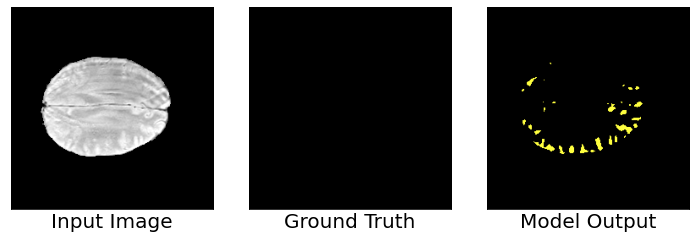

Steps: 2000, Loss:0.8484520316123962
Accurary: 0.9852604269981384
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 0.9852604166692256]
Gradient min:-0.9074861407279968, max:0.7496283650398254

Epochs  2



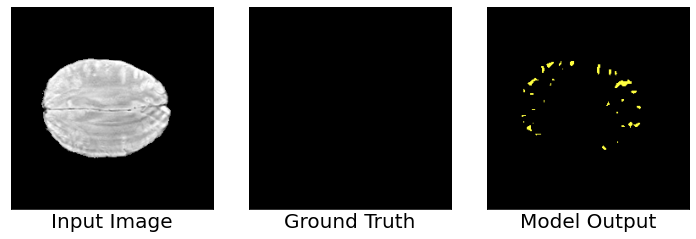

Steps: 2000, Loss:0.8025234937667847
Accurary: 0.9914757013320923
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 0.9914756944459243]
Gradient min:-1.1803226470947266, max:0.6253991723060608

Epochs  3



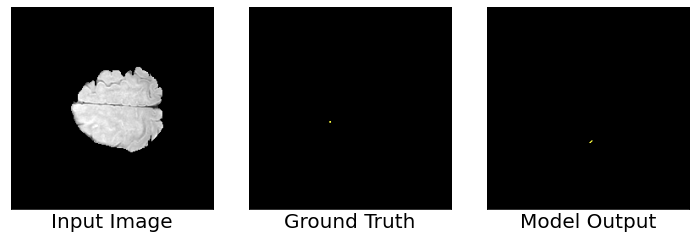

Steps: 2000, Loss:0.9438924789428711
Accurary: 0.9998263716697693
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 2.4999937500156254e-06]
Specificity: [1.0, 1.0, 0.9998958260990527]
Gradient min:-0.6668124794960022, max:0.3647056519985199

Epochs  4



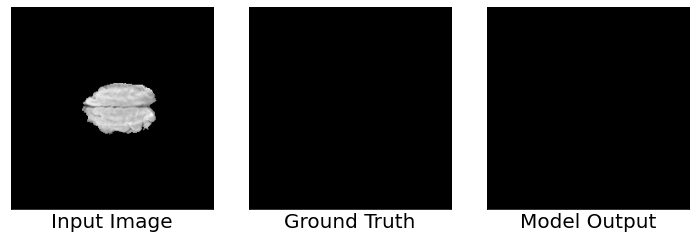

Steps: 2000, Loss:0.6940653324127197
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03093218244612217, max:0.1853702813386917

Epochs  5



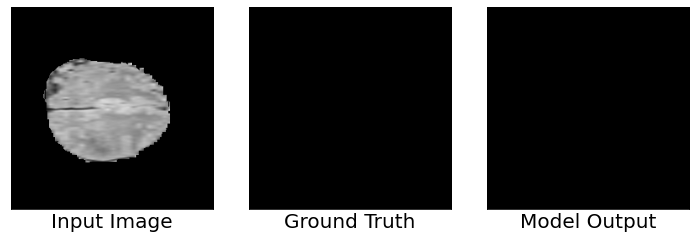

Steps: 2000, Loss:0.8057446479797363
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.24681177735328674, max:0.2269943654537201

-----------<Summary for Epoch:5>------------
Mean Accuracy: 0.9904887676239014
Mean Dice coefficient: [0.69250389 0.70331044 0.54336781]
Mean Sensitivity: [0.82477958 0.84800812 0.77164327]
Mean Specificity: [0.99835277 0.99834634 0.99790671]
------------------------------------------------



In [8]:
epochs = 1
#change remainder epochs 
pre_epochs = 25 #previous epochs
max_epochs = 30
re_epochs = max_epochs - pre_epochs #remainder epochs 
#list
loss_list = []
acc_list = []
loss_inner = []
#load model weights 
if pre_epochs!=0:
    model.load_weights('gdrive/My Drive/BraTS20/model_weights/model_{}.h5'.format(ver))
    upp_bound = re_epochs
else:
    upp_bound = max_epochs
#----training---------------------
while epochs <= upp_bound:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    dirs = os.listdir(path)
    end_i = int(np.ceil(369/5))
    for i in range(0, end_i):
        stack_list = []
        if i<end_i-1:
            end_j= 5*(i+1)
        else:
            end_j = 5*i+(369%5)
        for j in range(5*i, end_j):
            read_path = os.path.join(path,dirs[j])
            inp_image = np.load(read_path)
            for imgs in inp_image:
                if np.min(imgs[:,:,0])==np.max(imgs[:,:,0]):
                    continue
                else:
                    stack_list.append(imgs)
        arr = np.array(stack_list)
        tensor = tf.data.Dataset.from_tensor_slices(arr).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in tensor:
            #data agumentation
            imgs = data_aug(imgs)
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        #save weights for every 5 epochs 
        model.save_weights('gdrive/My Drive/BraTS20/model_weights/model_{}.h5'.format(ver))
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [9]:
model.save_weights('gdrive/My Drive/BraTS20/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [10]:
model.load_weights('gdrive/My Drive/BraTS20/model_weights/model_{}.h5'.format(ver))
def val_fn(image, label):
    model.trainable = False
    model_output = model(image)
    loss = custom_loss(label, model_output)
    return model_output, loss

In [11]:
# tfrecords_val = 'gdrive/My Drive/BraTS20/BraTS20_tfrecords03/LGG/'

# steps = 1
# acc_list = []
# for tf_re in sorted(os.listdir(tfrecords_val)):
#     tf_dir = os.path.join(tfrecords_val+tf_re)
#     dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
#     dc_app = []
#     sens_app = []
#     spec_app = []
#     for imgs in dataset:
#         image = imgs[:,:,:,:4]
#         label = imgs[:,:,:,-1]
#         label = tf.where(label==4,3,label)
#         #for simplicity label 4 will be converted to 3 for sparse encoding
#         label = tf.keras.utils.to_categorical(label, num_classes=4)
#         img_seg, loss = val_fn(image, label) #validation function 
#         #map from sparse to label
#         img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
#         label = tf.math.argmax(label,-1,output_type=tf.int32)
#         #accuracy of the output values for that batch
#         acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
#         dc_list, sens_list, spec_list =compute_metric(label,img_seg)
#         #append
#         acc_list.append(acc)
#         dc_app.append(dc_list)
#         sens_app.append(sens_list)
#         spec_app.append(spec_list)
#         #output
#         if steps%100==0:
# #             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
#             input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
#             caption = ['Input Image', 'Ground Truth', 'Model Output']
#             plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
#             acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
#             print("Steps: {}, Loss:{}".format(steps, loss))
#             print("Accuracy: {}".format(acc_stp))
#             print("Dice coefficient: {}".format(dc_list))
#             print("Sensitivity: {}".format(sens_list))
#             print("Specificity: {}".format(spec_list))
#         steps+=1
#     mean_dc = np.mean(np.array(dc_app),0)
#     mean_sens = np.mean(np.array(sens_app),0)
#     mean_spec = np.mean(np.array(spec_app),0)
#     print("Mean Accuracy: {}".format(np.mean(acc_list)))
#     print("Mean Dice coefficient: {}".format(mean_dc))
#     print("Mean Sensitivity: {}".format(mean_sens))
#     print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 240, 240, 64) 336         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 240, 240, 64) 4416        separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 64) 0           separable_conv2d_1[0][0]         
_______________________________________________________________________________________